# Vehicle trajectory tracking

Here, we've designed a Linear Model Predictive Controller (MPC) to track the desired path while enforcing the bounds on inputs (assuming kinematic bicycle model for the vehicle).

# System models
The state of the vehicle is defined as the position $\left[x, y\right]$, yaw angle $\psi$, and the velocity $v$. The vehicle is controlled by the steering angle of front wheel $\delta$ and the acceleration $a$.

Thus, the dynamics of the vehicle can be expressed as:

$$
\frac{d}{dt} \begin{bmatrix} x \\ y \\ \psi \\ v \end{bmatrix}
= \begin{bmatrix} v\cos(\psi + \beta) \\
                  v\sin(\psi + \beta) \\
                  \frac{v}{L_r} \sin\beta \\
                  a
  \end{bmatrix}, \text{with } \beta := \arctan(\frac{L_r}{L_r + L_f} \arctan \delta).
$$

where $L_r$ and $L_f$ is distance from the rear or front axes to the center of the vehicle. Let the state be $s:= [x, y, \psi, v]$.

We apply the explicit Euler integration to obtain the discrete-time dynamics model of $\dot{s}=f(s, u) \ \ \text{as}\ \ s_{k+1} = s_{k} + f(s_k, u_k) \Delta t.$

For more details about this model: https://link.springer.com/book/10.1007/978-1-4614-1433-9

# Linearization around reference trajectory

Given the reference trajectory $\left(\bar{s}_{k}, \bar{u}_{k}\right)_{k=0,2,\cdots, N-1}$, we have the linearized system as:

$ (s_{k+1} - \bar{s}_{k+1}) = \frac{df(s_k, u_k)}{ds_k}|_{\bar{s}_k}(s_{k} - \bar{s}_k) + \frac{df(s_k, u_k)}{du_k}|_{\bar{u}_k}(u_{k} - \bar{u}_k) + h.o.t(s_k, u_k)$, where $h.o.t()$ denotes the terms with order higher than 1. 

Then we have the perturbed state dynamics as:

$ \delta s_{k+1} = A_k\delta s_{k} + B_k\delta u_{k} $, with $A_k:= \frac{df(s_k, u_k)}{ds_k}|_{\bar{s}_k}$ and $\frac{df(s_k, u_k)}{du_k}|_{\bar{u}_k}$.

We have 

$$A_k(s_k) = \begin{bmatrix} {\color{red}1} & {\color{red}0} & -\Delta tv\sin(\psi + \arctan((L_r\arctan(\delta))/(L_f + L_r))) &  \Delta t\cos(\psi + \arctan((L_r\arctan(\delta))/(L_f + L_r))) \\
                             0 & 1 &  \Delta tv\cos(\psi + \arctan((L_r\arctan(\delta))/(L_f + L_r)))&                              \Delta t\sin(\psi + \arctan((L_r\arctan(\delta))/(L_f + L_r))) \\
                             0 & 0 &                                                   1& (\Delta t\arctan(\delta))/(((L_r^2\arctan(\delta)^2)/(L_f + L_r)^2 + 1)^{(1/2)}(L_f + L_r)) \\
                             0 & 0 &                                                   0&                                                                             1 \\ \end{bmatrix}
$$

$$
B_k(s_k)   = \begin{bmatrix} 0& -(\Delta tL_rv\sin(\psi + \arctan((L_r\arctan(\delta))/(L_f + L_r))))/((\delta^2 + 1)((L_r^2\arctan(\delta)^2)/(L_f + L_r)^2 + 1)(L_f + L_r)) \\
                             0&  (\Delta tL_rv\cos(\psi + \arctan((L_r\arctan(\delta))/(L_f + L_r))))/((\delta^2 + 1)((L_r^2\arctan(\delta)^2)/(L_f + L_r)^2 + 1)(L_f + L_r)) \\
                             0&                                               (\Delta t v)/((\delta^2 + 1)((L_r^2\arctan(\delta)^2)/(L_f + L_r)^2 + 1)^{3/2}(L_f + L_r)) \\
                             \Delta t&                                                                                                                               0 \\ \end{bmatrix}
$$

# Approach to solve:

Implement the convex MPC using cvx. The key variables here are the matrices L, Q, and R that've required fine-tuning. The variable 'N' is the preview horizon.

$
\begin{equation}
    \begin{aligned}
    \min_{\delta s_k, \delta u_k} & \ \delta s_N^TL\delta s_N + \sum_{k=0}^{N-1} \delta s_k^TQ\delta s_k + \delta u_k^TR\delta u_k \\ 
    \text{s.t. } &\delta s_{k+1} = A_k\delta s_{k} + B_k\delta u_k, \ k = 0, \dots, N-1, \\
                 & u_{\min} - \bar{u}_k \le \delta u_k \le u_{\max} - \bar{u}_k, \\
                 &\delta s_0 = \delta s_{init}.
    \end{aligned}
\end{equation}
$

## Requirement:

1. Track the reference trajectory as close as possible.

2. The input constraints are satisfied for MPC case. 

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt

from utils import *

from controller_cmpc import * 

In [2]:
param = {"h":0.05, "T":15., "L_f": 1., "L_r":1., "a_lim": [-10.0, 4.], "delta_lim": [-0.8, 0.8]}
Sim = BicycleSim(param)
u_bar, x_bar = Sim.GenRef(10, 23)

In [3]:
preview = 20
x0 = np.array([2, 2, 3.14 * 0.5, 2])
Jac = Setup_Derivative(param)

x_log, u_log = Sim.SimVehicle(x_bar, u_bar, preview, x0, lambda x, u, xint: Controller_CMPC(x, u, xint, Jac, param) )

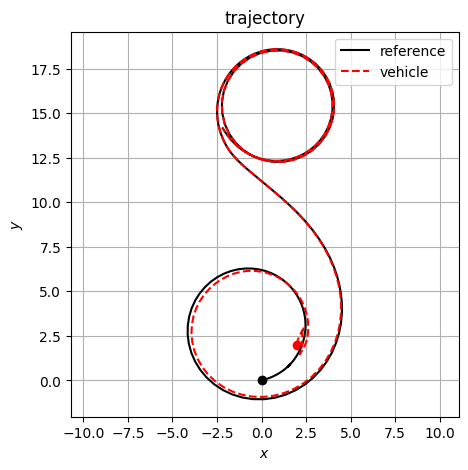

traj Root Mean Square Error: 0.9918087116399193


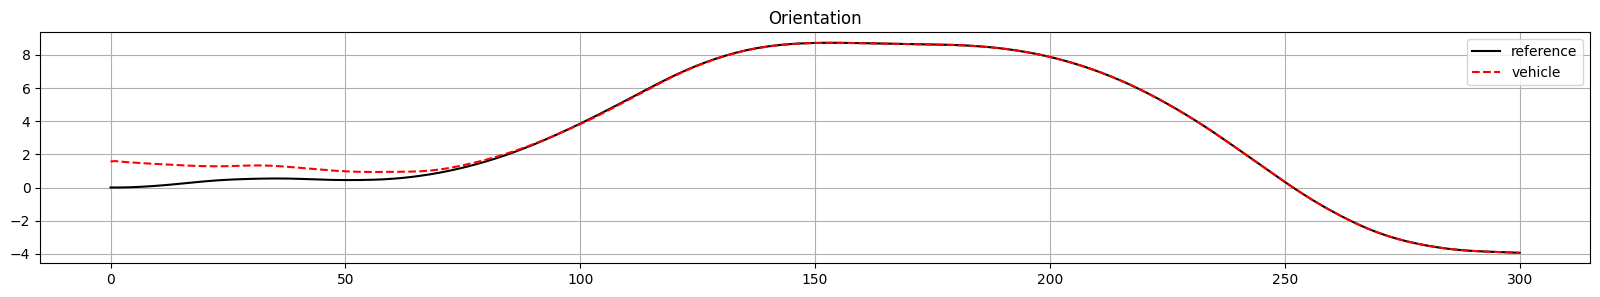

or Root Mean Square Error: 0.42754914904591707


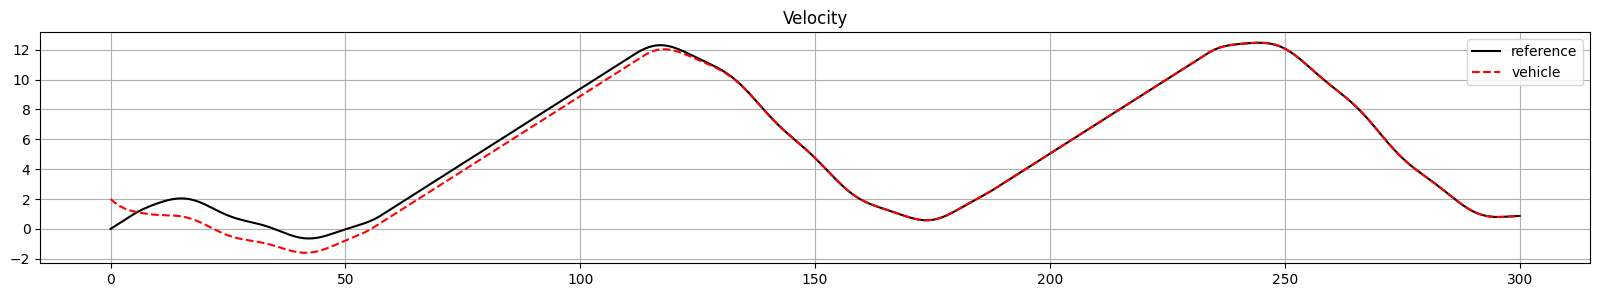

vel Root Mean Square Error: 0.509289229020475


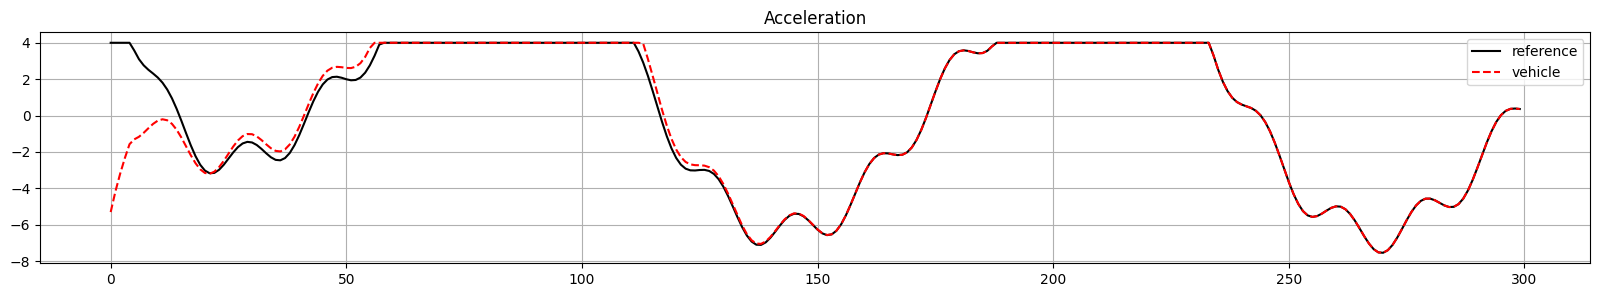

acn Root Mean Square Error: 1.1304337391462063


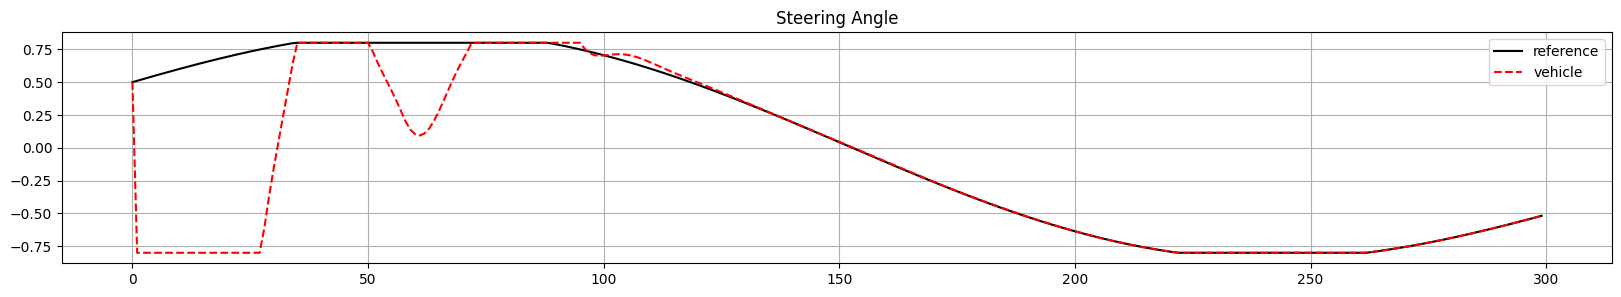

In [4]:
plt.figure(figsize=(5, 5))
plt.plot(x_bar[0, 0], x_bar[0, 1], 'ko-')
plt.plot(x_log[0, 0], x_log[0, 1], 'ro-')

plt.plot(x_bar[:, 0], x_bar[:, 1], 'k-', label = "reference")
plt.plot(x_log[:, 0], x_log[:, 1], 'r--', label = "vehicle")
plt.axis('equal')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('trajectory')
plt.legend()
plt.grid()
plt.show()
rmse = np.sqrt(np.mean((x_bar[:, 0] - x_log[:, 0]) ** 2 + (x_bar[:, 1] - x_log[:, 1]) ** 2))

print("traj Root Mean Square Error:", rmse)
plt.figure(figsize=(20, 3))
plt.plot(x_bar[:, 2], 'k-', label = "reference")
plt.plot(x_log[:, 2], 'r--', label = "vehicle")
plt.title('Orientation')
plt.legend()
plt.grid()
plt.show()
rmse = np.sqrt(np.mean((x_bar[:, 2] - x_log[:, 2]) ** 2))

print("or Root Mean Square Error:", rmse)

plt.figure(figsize=(20, 3))
plt.plot(x_bar[:, 3], 'k-', label = "reference")
plt.plot(x_log[:, 3], 'r--', label = "vehicle")
plt.title('Velocity')
plt.legend()
plt.grid()
plt.show()
rmse = np.sqrt(np.mean((x_bar[:, 3] - x_log[:, 3]) ** 2))

print("vel Root Mean Square Error:", rmse)

plt.figure(figsize=(20, 3))
plt.plot(u_bar[:, 0], 'k-', label = "reference")
plt.plot(u_log[:, 0], 'r--', label = "vehicle")
plt.title('Acceleration')
plt.legend()
plt.grid()
plt.show()
rmse = np.sqrt(np.mean((u_bar[:, 0] - u_log[:, 0]) ** 2))

print("acn Root Mean Square Error:", rmse)

plt.figure(figsize=(20, 3))
plt.plot(u_bar[:, 1], 'k-', label = "reference")
plt.plot(u_log[:, 1], 'r--', label = "vehicle")
plt.title('Steering Angle')
plt.legend()
plt.grid()
plt.show()

# Now lets animate the vehicle

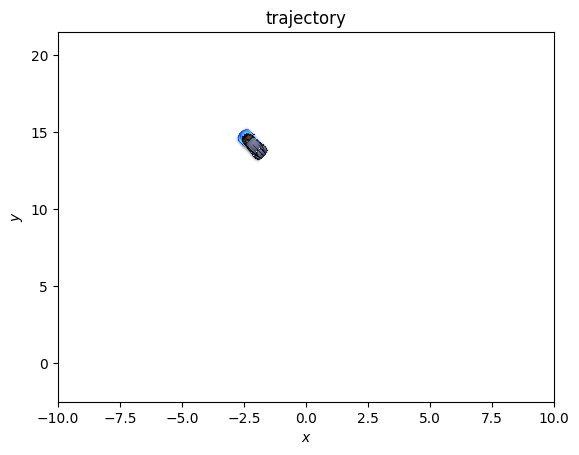

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from scipy.ndimage import rotate

ego_position_x = x_log[:, 0]
ego_position_y = x_log[:, 1]
ego_orientation = x_log[:, 2]  # Orientation of the car

# Set up the figure and axis
fig, ax = plt.subplots()

ax.set_xlim(-10, 10)
ax.set_ylim(-2.5, 21.5)

# Load an image to use as the cursor (point)
ego_car_image = plt.imread(r'C:\Users\Lenovo\Downloads\SelfDriveSuite\Vehicle Control\Trajectory tracking\assets\bugatti.jpg')

# Create OffsetImage objects for the moving images
ego_vehicle_image = OffsetImage(ego_car_image, zoom=0.04)

# Create AnnotationBbox objects for placing the images on the plot
ego_vehicle_ab = AnnotationBbox(ego_vehicle_image, (ego_position_x[0], ego_position_y[0]), frameon=False)

# Add the AnnotationBbox objects to the axis
ax.add_artist(ego_vehicle_ab)

# Container for the AnnotationBbox objects
container = {
    'ego_vehicle_ab': ego_vehicle_ab
}
# ax.xlabel('$x$')
ax.set_xlabel('$x$')
# ax.ylabel('$y$')
ax.set_ylabel('$y$')
ax.set_title('trajectory')

def init():
    container['ego_vehicle_ab'].xy = (ego_position_x[0], ego_position_y[0])
    return container['ego_vehicle_ab']

def update(frame):
    # Remove the previous AnnotationBbox objects
    container['ego_vehicle_ab'].remove()

    # Rotate the car image based on the vehicle's orientation
    angle = np.rad2deg(ego_orientation[frame])
    rotated_image_array = rotate(ego_car_image, angle, reshape=True, mode='constant', cval=255)
    rotated_image = OffsetImage(rotated_image_array, zoom=0.04)
    
    # Create new AnnotationBbox objects with updated positions and orientation
    container['ego_vehicle_ab'] = AnnotationBbox(rotated_image, (ego_position_x[frame], ego_position_y[frame]), frameon=False)

    # Add the new AnnotationBbox objects to the axis
    ax.add_artist(container['ego_vehicle_ab'])

    return container['ego_vehicle_ab']

ani = animation.FuncAnimation(fig, update, frames=len(ego_position_y), init_func=init, interval=100, repeat=False)

# Save the animation
ani.save('vehicle_simulation.mp4', writer='ffmpeg')

